In [9]:
# Motif identification

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import poisson
from pathlib import Path
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import os
import pickle

# ==================================================================================================
# Utility Functions
# ==================================================================================================

def load_optimal_states(base_dir, mode):
    """
    Load optimal states for a specific mode (EC or EO).
    """
    file_name = f"median_optimal_state_{mode}.txt"
    file_path = Path(base_dir) / file_name
    
    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()
            # Extract the number from format "Median Optimal State (XX): Y.00"
            optimal_states = int(float(content.split(': ')[1]))
        return optimal_states
    except Exception as e:
        print(f"Error loading optimal states for {mode}: {str(e)}")
        return None

def load_participant_data(base_dir, participant_id, mode):
    """
    Load all necessary files for a single participant and mode.
    
    Parameters:
    -----------
    base_dir : str or Path
        Base directory containing participant data
    participant_id : str
        Participant identifier
    mode : str
        Data collection mode ('EC' or 'EO')
        
    Returns:
    --------
    dict
        Dictionary containing all loaded data for the participant
    """
    participant_dir = Path(base_dir) / participant_id / mode
    data = {}
    
    try:
        # Load correlation matrices
        matrices_path = participant_dir / f"{participant_id}_correlation_matrices.npy.npz"
        if matrices_path.exists():
            matrices_data = np.load(matrices_path, allow_pickle=True)
            correlation_matrices = {}
            for key in matrices_data.files:
                state, window = map(int, key.split('_'))
                correlation_matrices[(state, window)] = matrices_data[key][:-2, :-2]
            data['correlation_matrices'] = correlation_matrices
        
        # Load state sequence and probabilities
        state_seq_path = participant_dir / f"{participant_id}_state_sequence.npy"
        state_prob_path = participant_dir / f"{participant_id}_state_probs.npy"
        if state_seq_path.exists() and state_prob_path.exists():
            data['state_sequence'] = np.load(state_seq_path)
            data['state_probs'] = np.load(state_prob_path)
        
        # Load temporal features
        temporal_path = participant_dir / f"{participant_id}_temporal_features.npz"
        if temporal_path.exists():
            temporal_data = np.load(temporal_path)
            data['temporal_features'] = {
                'fractional_occupancy': temporal_data['fractional_occupancy'],
                'transition_probabilities': temporal_data['transition_probabilities'],
                'mean_lifetime': temporal_data['mean_lifetime'],
                'mean_interval_length': temporal_data['mean_interval_length']
            }
        
        # Load network assignments
        network_path = participant_dir / f"{participant_id}_network_assignment.npy"
        if network_path.exists():
            data['network_assignment'] = np.load(network_path, allow_pickle=True).item()
            
        return data
    
    except Exception as e:
        print(f"Error loading data for participant {participant_id}, mode {mode}: {str(e)}")
        return None

def load_tcoa_data(base_dir):
    """
    Load data for TCOA participants only.
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing participant data
        
    Returns:
    --------
    dict
        Dictionary with structure {participant: {mode: data_dict}}
    """
    # Define TCOA participant IDs
    tcoa_participants = ['401', '402', '403', '404', '406', '407', '408', '409', '410', 
                         '411', '412', '413', '414', '415', '416']
    
    # Load optimal states for each mode
    optimal_states = {}
    for mode in ['EC', 'EO']:
        optimal_states[mode] = load_optimal_states(base_dir, mode)
        print(f"Loaded optimal states for {mode}: {optimal_states[mode]}")
    
    # Initialize data structure
    tcoa_data = {}
    
    # Load data for each TCOA participant
    print(f"\nProcessing TCOA participants:")
    
    for participant in tcoa_participants:
        print(f"Loading participant {participant}...", end=' ')
        tcoa_data[participant] = {}
        
        for mode in ['EC', 'EO']:
            data = load_participant_data(base_dir, participant, mode)
            if data is not None:
                data['optimal_states'] = optimal_states[mode]  # Add optimal states to participant data
                tcoa_data[participant][mode] = data
                print(f"{mode} loaded", end=' ')
        
        print()  # New line after processing both modes
    
    return tcoa_data, optimal_states

def create_temporal_mapping(state_sequence, correlation_matrices):
    """
    Create a mapping between the state sequence and the temporal windows in the connectivity data.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    correlation_matrices : dict
        Dictionary of correlation matrices with keys as (state, window) tuples
    
    Returns:
    --------
    list
        List of (state, window) tuples corresponding to each timepoint in the state sequence
    """
    # Collect all unique (state, window) pairs from correlation matrices
    all_pairs = set(correlation_matrices.keys())
    
    # Create a mapping of states to their corresponding windows
    state_to_windows = defaultdict(list)
    for state, window in all_pairs:
        state_to_windows[state].append(window)
    
    # Sort the windows for each state
    for state in state_to_windows:
        state_to_windows[state] = sorted(state_to_windows[state])
    
    # Create the temporal mapping
    temporal_mapping = []
    window_index = {state: 0 for state in state_to_windows}
    
    for state in state_sequence:
        if state in state_to_windows and window_index[state] < len(state_to_windows[state]):
            window = state_to_windows[state][window_index[state]]
            temporal_mapping.append((state, window))
            window_index[state] += 1
        else:
            # If we've run out of windows for this state, use the last available or None
            if state in state_to_windows and state_to_windows[state]:
                window = state_to_windows[state][-1]
                temporal_mapping.append((state, window))
            else:
                temporal_mapping.append((state, None))
    
    return temporal_mapping

# ==================================================================================================
# Motif Analysis with Connectivity Matrices
# ==================================================================================================

def find_optimal_motif_length(state_sequence, max_length=30, min_occurrences=0):
    """
    Find optimal motif length using information gain ratio.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    max_length : int
        Maximum motif length to consider
    min_occurrences : int
        Minimum number of occurrences required for a motif (should be 0 for optimal length determination)
    
    Returns:
    --------
    int
        Optimal motif length
    """
    sequence_length = len(state_sequence)
    information_gains = []

    for length in range(2, max_length + 1):
        # Count motifs of current length
        motifs = Counter()
        for i in range(sequence_length - length + 1):
            motif = tuple(state_sequence[i:i + length])
            motifs[motif] += 1

        # Filter by minimum occurrences
        filtered_motifs = {k: v for k, v in motifs.items() if v >= min_occurrences}

        if not filtered_motifs:
            break

        # Calculate entropy
        total_motifs = sum(filtered_motifs.values())
        probabilities = [count / total_motifs for count in filtered_motifs.values()]
        entropy = -sum(p * np.log2(p) for p in probabilities)

        # Calculate information gain ratio (normalized by motif length)
        information_gain = entropy / length
        information_gains.append((length, information_gain))

    if not information_gains:
        return 2  # Default to minimum length if no valid motifs found

    # Find length with maximum information gain ratio
    optimal_length = max(information_gains, key=lambda x: x[1])[0]

    print(f"\nInformation gains by length:")
    for length, gain in information_gains:
        print(f"Length {length}: {gain:.4f}")
    print(f"Optimal motif length: {optimal_length}")

    return optimal_length

def find_motifs_with_connectivity(state_sequence, correlation_matrices, temporal_mapping, 
                                  motif_length=None, min_occurrences=3):
    """
    Find recurring motifs in the state sequence and their corresponding connectivity matrices.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    correlation_matrices : dict
        Dictionary of correlation matrices with keys as (state, window) tuples
    temporal_mapping : list
        List of (state, window) tuples corresponding to each timepoint in the state sequence
    motif_length : int, optional
        Length of motifs to search for. If None, will use optimal length.
    min_occurrences : int
        Minimum number of occurrences to consider
    
    Returns:
    --------
    dict
        Dictionary of motifs, their counts, and corresponding connectivity matrices
    """
    # If motif_length is not provided, find the optimal length
    if motif_length is None:
        motif_length = find_optimal_motif_length(state_sequence, max_length=30, min_occurrences=0)
        print(f"Using optimal motif length: {motif_length}")
        
    motifs = defaultdict(list)
    
    for i in range(len(state_sequence) - motif_length + 1):
        # Extract the motif (state sequence)
        motif = tuple(state_sequence[i:i + motif_length])
        
        # Extract the corresponding (state, window) tuples for this motif
        motif_keys = temporal_mapping[i:i + motif_length]
        
        # Only include motifs where all states have valid windows
        if all(key is not None and key in correlation_matrices for key in motif_keys):
            # Store both the motif and its corresponding connectivity matrices
            motifs[motif].append(motif_keys)
    
    # Filter by minimum occurrences and convert to final format
    filtered_motifs = {}
    for motif, motif_keys_list in motifs.items():
        if len(motif_keys_list) >= min_occurrences:
            # Now for each occurrence of the motif, store the corresponding connectivity matrices
            connectivity_matrices = []
            for motif_keys in motif_keys_list:
                motif_connectivity = [correlation_matrices[key] for key in motif_keys]
                connectivity_matrices.append(motif_connectivity)
            
            filtered_motifs[motif] = {
                'count': len(motif_keys_list),
                'keys': motif_keys_list,
                'connectivity_matrices': connectivity_matrices
            }
    
    return filtered_motifs

def calculate_expected_occurrences(state_sequence, motif, n_permutations=1000):
    """
    Calculate the expected number of occurrences of a motif under a null model.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    motif : tuple
        Tuple representing the motif
    n_permutations : int
        Number of permutations for the null model
    
    Returns:
    --------
    tuple
        Mean and standard deviation of expected occurrences
    """
    motif_length = len(motif)
    observed_counts = []

    for _ in range(n_permutations):
        shuffled_sequence = np.random.permutation(state_sequence)
        count = sum(1 for i in range(len(shuffled_sequence) - motif_length + 1)
                    if tuple(shuffled_sequence[i:i + motif_length]) == motif)
        observed_counts.append(count)

    return np.mean(observed_counts), np.std(observed_counts)

def analyze_motifs_with_connectivity(state_sequence, correlation_matrices, temporal_mapping,
                                     motif_length=None, min_occurrences=3, n_permutations=1000):
    """
    Analyze motifs in the state sequence and their corresponding connectivity patterns.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    correlation_matrices : dict
        Dictionary of correlation matrices with keys as (state, window) tuples
    temporal_mapping : list
        List of (state, window) tuples corresponding to each timepoint in the state sequence
    motif_length : int, optional
        Length of motifs to search for. If None, will find optimal length.
    min_occurrences : int
        Minimum number of occurrences to consider
    n_permutations : int
        Number of permutations for the null model
    
    Returns:
    --------
    list
        List of significant motifs with their statistics and connectivity patterns
    """
    motifs = find_motifs_with_connectivity(state_sequence, correlation_matrices, temporal_mapping,
                                           motif_length, min_occurrences)
    significant_motifs = []

    for motif, motif_data in motifs.items():
        count = motif_data['count']
        expected_mean, expected_std = calculate_expected_occurrences(state_sequence, motif, n_permutations)
        z_score = (count - expected_mean) / expected_std if expected_std > 0 else 0
        p_value = 1 - poisson.cdf(count, expected_mean)

        # Calculate average connectivity matrix for each state in the motif
        avg_connectivity = []
        for state_idx in range(len(motif)):
            # Extract connectivity matrices for this state position across all occurrences
            state_matrices = [matrices[state_idx] for matrices in motif_data['connectivity_matrices']]
            # Calculate average
            avg_matrix = np.mean(state_matrices, axis=0)
            avg_connectivity.append(avg_matrix)

        significant_motifs.append({
            'motif': motif,
            'count': count,
            'expected_mean': expected_mean,
            'expected_std': expected_std,
            'z_score': z_score,
            'p_value': p_value,
            'avg_connectivity': avg_connectivity,
            'connectivity_matrices': motif_data['connectivity_matrices']
        })

    return sorted(significant_motifs, key=lambda x: x['z_score'], reverse=True)

def analyze_motifs_dynamic_with_connectivity(state_sequence, correlation_matrices, temporal_mapping,
                                            max_length=30, min_occurrences=3, n_permutations=1000):
    """
    Analyze motifs with dynamically determined optimal length, including connectivity patterns.
    
    Parameters:
    -----------
    state_sequence : ndarray
        Sequence of states
    correlation_matrices : dict
        Dictionary of correlation matrices with keys as (state, window) tuples
    temporal_mapping : list
        List of (state, window) tuples corresponding to each timepoint in the state sequence
    max_length : int
        Maximum motif length to consider
    min_occurrences : int
        Minimum number of occurrences required for a motif
    n_permutations : int
        Number of permutations for the null model
    
    Returns:
    --------
    list
        List of significant motifs with their statistics and connectivity patterns
    """
    # Determine optimal motif length (using min_occurrences=0 for this step)
    optimal_length = find_optimal_motif_length(state_sequence, max_length, min_occurrences=0)
    
    print(f"\nAnalyzing motifs using optimal length: {optimal_length}")
    
    # Use the determined optimal length for motif analysis (with actual min_occurrences)
    return analyze_motifs_with_connectivity(
        state_sequence, correlation_matrices, temporal_mapping,
        motif_length=optimal_length,
        min_occurrences=min_occurrences,
        n_permutations=n_permutations
    )

def plot_motif_results(significant_motifs, top_n=10, save_path=None):
    """
    Plot the results of the motif analysis.
    
    Parameters:
    -----------
    significant_motifs : list
        List of significant motifs with their statistics
    top_n : int
        Number of top motifs to plot
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    if not significant_motifs:
        print("No significant motifs to plot.")
        return None
        
    top_motifs = significant_motifs[:min(top_n, len(significant_motifs))]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot observed vs expected occurrences
    motifs = [' → '.join(map(str, m['motif'])) for m in top_motifs]
    observed = [m['count'] for m in top_motifs]
    expected = [m['expected_mean'] for m in top_motifs]

    x = range(len(motifs))
    ax1.bar(x, observed, alpha=0.8, label='Observed')
    ax1.bar(x, expected, alpha=0.5, label='Expected')
    ax1.set_xlabel('Motif')
    ax1.set_ylabel('Occurrences')
    ax1.set_title('Top Motifs: Observed vs Expected Occurrences')
    ax1.set_xticks(x)
    ax1.set_xticklabels(motifs, rotation=45, ha='right')
    ax1.legend()

    # Plot z-scores
    z_scores = [m['z_score'] for m in top_motifs]
    ax2.bar(x, z_scores)
    ax2.set_xlabel('Motif')
    ax2.set_ylabel('Z-score')
    ax2.set_title('Top Motifs: Z-scores')
    ax2.set_xticks(x)
    ax2.set_xticklabels(motifs, rotation=45, ha='right')
    # Add a horizontal line at z=1.96 (95% confidence)
    ax2.axhline(y=1.96, color='r', linestyle='--', label='p=0.05 threshold')
    ax2.legend()

    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig

def plot_motif_connectivity(motif_data, networks=None, title=None):
    """
    Plot the average connectivity matrices for a specific motif.
    
    Parameters:
    -----------
    motif_data : dict
        Dictionary containing motif information, including avg_connectivity
    networks : dict, optional
        Dictionary mapping regions to networks for visualization
    title : str, optional
        Title for the plot
    """
    motif = motif_data['motif']
    motif_str = ' -> '.join(map(str, motif))
    
    if title is None:
        title = f"Connectivity Patterns for Motif: {motif_str}"
    
    num_states = len(motif)
    fig, axes = plt.subplots(1, num_states, figsize=(5 * num_states, 5))
    
    if num_states == 1:
        axes = [axes]
    
    for i, (state, matrix) in enumerate(zip(motif, motif_data['avg_connectivity'])):
        ax = axes[i]
        
        # Plot connectivity matrix as heatmap
        im = ax.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)
        
        ax.set_title(f"State {state}")
        ax.set_xlabel("Region")
        ax.set_ylabel("Region")
        
        # Add colorbar
        if i == num_states - 1:
            fig.colorbar(im, ax=ax, label="Correlation")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_motif_connectivity(motif_data, networks=None, save_path=None):
    """
    Compare connectivity differences between states in a motif.
    
    Parameters:
    -----------
    motif_data : dict
        Dictionary containing motif information, including avg_connectivity
    networks : dict, optional
        Dictionary mapping regions to networks for visualization
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    motif = motif_data['motif']
    motif_str = ' → '.join(map(str, motif))
    
    num_states = len(motif)
    if num_states < 2:
        print("Need at least 2 states in the motif to compare connectivity.")
        return None
    
    # Compute connectivity differences between consecutive states
    diff_matrices = []
    for i in range(num_states - 1):
        diff = motif_data['avg_connectivity'][i+1] - motif_data['avg_connectivity'][i]
        diff_matrices.append(diff)
    
    # Plot connectivity differences
    fig, axes = plt.subplots(1, len(diff_matrices), figsize=(5 * len(diff_matrices), 5))
    
    if len(diff_matrices) == 1:
        axes = [axes]
    
    for i, diff_matrix in enumerate(diff_matrices):
        ax = axes[i]
        
        # Plot difference matrix as heatmap
        vmax = max(abs(np.min(diff_matrix)), abs(np.max(diff_matrix)))
        im = ax.imshow(diff_matrix, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        
        ax.set_title(f"State {motif[i]} → State {motif[i+1]}")
        ax.set_xlabel("Region")
        ax.set_ylabel("Region")
        
        # Add colorbar
        if i == len(diff_matrices) - 1:
            fig.colorbar(im, ax=ax, label="Correlation Difference")
    
    plt.suptitle(f"Connectivity Changes in Motif: {motif_str}")
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig

# ==================================================================================================
# Directory Creation Helper Function
# ==================================================================================================

def create_output_directories(base_dir="motif_results"):
    """
    Create the directory structure for saving motif analysis results.
    
    Parameters:
    -----------
    base_dir : str
        Base directory name
        
    Returns:
    --------
    dict
        Dictionary of created directory paths
    """
    # Create main directory
    os.makedirs(base_dir, exist_ok=True)
    
    # Create subdirectories for each mode
    ec_dir = os.path.join(base_dir, "EC")
    eo_dir = os.path.join(base_dir, "EO")
    os.makedirs(ec_dir, exist_ok=True)
    os.makedirs(eo_dir, exist_ok=True)
    
    return {
        'base': base_dir,
        'EC': ec_dir,
        'EO': eo_dir
    }

# ==================================================================================================
# Main Analysis Function
# ==================================================================================================

def run_motif_analysis_for_participant(participant_data, mode, participant_id, output_dirs=None, 
                                      max_length=20, min_occurrences=0, n_permutations=1000):
    """
    Run motif analysis for a specific participant and mode.
    
    Parameters:
    -----------
    participant_data : dict
        Dictionary containing participant data
    mode : str
        Data collection mode ('EC' or 'EO')
    participant_id : str
        Participant identifier
    output_dirs : dict
        Dictionary of output directory paths
    max_length : int
        Maximum motif length to consider
    min_occurrences : int
        Minimum number of occurrences required for a motif
    n_permutations : int
        Number of permutations for the null model
    
    Returns:
    --------
    dict
        Results of the motif analysis
    """
    if mode not in participant_data:
        print(f"Mode {mode} not available for this participant.")
        return None
    
    data = participant_data[mode]
    
    if 'state_sequence' not in data or 'correlation_matrices' not in data:
        print(f"Required data missing for this participant in mode {mode}.")
        return None
    
    state_sequence = data['state_sequence']
    correlation_matrices = data['correlation_matrices']
    networks = data.get('network_assignment')
    
    # Create temporal mapping between state sequence and correlation matrices
    temporal_mapping = create_temporal_mapping(state_sequence, correlation_matrices)
    
    # Create participant output directory if needed
    participant_dir = None
    if output_dirs and mode in output_dirs:
        participant_dir = os.path.join(output_dirs[mode], participant_id)
        os.makedirs(participant_dir, exist_ok=True)
    
    # Run the dynamic motif analysis with connectivity
    significant_motifs = analyze_motifs_dynamic_with_connectivity(
        state_sequence, correlation_matrices, temporal_mapping,
        max_length=max_length, min_occurrences=min_occurrences, n_permutations=n_permutations
    )
    
    if significant_motifs:
        # Plot the overall motif statistics and save if directory is provided
        if participant_dir:
            stats_path = os.path.join(participant_dir, f"{participant_id}_{mode}_motif_stats.png")
            fig_stats = plot_motif_results(significant_motifs, save_path=stats_path)
            plt.close(fig_stats) if fig_stats else None
        else:
            plot_motif_results(significant_motifs)
            plt.close()
        
        # Print and plot connectivity patterns for the top 3 motifs
        for i, motif_data in enumerate(significant_motifs[:3]):
            motif_str = ' → '.join(map(str, motif_data['motif']))
            print(f"\nMotif {i+1}: {motif_str}")
            print(f"Count: {motif_data['count']} (Expected: {motif_data['expected_mean']:.2f} ± {motif_data['expected_std']:.2f})")
            print(f"Z-score: {motif_data['z_score']:.2f}, p-value: {motif_data['p_value']:.4f}")
            
            # We skip plotting the connectivity matrices for individual states
            # but we do plot the connectivity differences between states
            if len(motif_data['motif']) > 1:  # Only if motif has more than one state
                if participant_dir:
                    conn_path = os.path.join(participant_dir, f"{participant_id}_{mode}_motif{i+1}_connectivity_changes.png")
                    fig_conn = compare_motif_connectivity(motif_data, networks, save_path=conn_path)
                    plt.close(fig_conn) if fig_conn else None
                else:
                    compare_motif_connectivity(motif_data, networks)
                    plt.close()
    
    return {
        'significant_motifs': significant_motifs,
        'temporal_mapping': temporal_mapping
    }

def run_group_analysis(tcoa_data, mode='EC', output_dirs=None, 
                        max_length=20, min_occurrences=0, n_permutations=1000):
    """
    Run motif analysis for the entire TCOA group.
    
    Parameters:
    -----------
    tcoa_data : dict
        Dictionary containing all TCOA participant data
    mode : str
        Data collection mode ('EC' or 'EO')
    output_dirs : dict
        Dictionary of output directory paths
    max_length : int
        Maximum motif length to consider
    min_occurrences : int
        Minimum number of occurrences required for a motif
    n_permutations : int
        Number of permutations for the null model
        
    Returns:
    --------
    dict
        Results of the group analysis
    """
    print(f"Running group-level motif analysis for TCOA participants in {mode} mode...")
    
    all_results = {}
    group_motifs = defaultdict(list)
    
    # Create group output directory if needed
    group_dir = None
    if output_dirs and mode in output_dirs:
        group_dir = os.path.join(output_dirs[mode], "group_results")
        os.makedirs(group_dir, exist_ok=True)
    
    # Run individual analysis for each participant
    for participant_id, participant_data in tcoa_data.items():
        print(f"\nProcessing participant {participant_id}...")
        results = run_motif_analysis_for_participant(
            participant_data, mode, participant_id, output_dirs,
            max_length, min_occurrences, n_permutations
        )
        
        if results:
            all_results[participant_id] = results
            
            # Group motifs across participants
            for motif_data in results['significant_motifs']:
                motif = motif_data['motif']
                group_motifs[motif].append({
                    'participant_id': participant_id,
                    'z_score': motif_data['z_score'],
                    'count': motif_data['count'],
                    'p_value': motif_data['p_value'],
                    'avg_connectivity': motif_data['avg_connectivity']
                })
    
    # Analyze group-level motifs
    print("\n\nGroup-Level Motif Analysis:")
    common_motifs = []
    
    for motif, occurrences in group_motifs.items():
        # Only consider motifs that appear in at least 50% of participants
        if len(occurrences) >= len(tcoa_data) * 0.5:  
            motif_str = ' → '.join(map(str, motif))
            
            # Calculate average z-score and p-value across participants
            avg_z_score = np.mean([occ['z_score'] for occ in occurrences])
            avg_p_value = np.mean([occ['p_value'] for occ in occurrences])
            
            # Calculate average connectivity matrices across participants
            motif_length = len(motif)
            avg_group_connectivity = []
            
            for state_idx in range(motif_length):
                participant_matrices = [occ['avg_connectivity'][state_idx] for occ in occurrences]
                avg_matrix = np.mean(participant_matrices, axis=0)
                avg_group_connectivity.append(avg_matrix)
            
            common_motifs.append({
                'motif': motif,
                'participant_count': len(occurrences),
                'participants': [occ['participant_id'] for occ in occurrences],
                'avg_z_score': avg_z_score,
                'avg_p_value': avg_p_value,
                'avg_connectivity': avg_group_connectivity
            })
    
    # Sort common motifs by the number of participants they appear in
    common_motifs.sort(key=lambda x: (x['participant_count'], x['avg_z_score']), reverse=True)
    
    # Print and visualize the most common motifs
    print(f"\nFound {len(common_motifs)} common motifs across TCOA participants:")
    
    for i, motif_data in enumerate(common_motifs[:5]):  # Top 5 common motifs
        motif_str = ' → '.join(map(str, motif_data['motif']))
        print(f"\nCommon Motif {i+1}: {motif_str}")
        print(f"Found in {motif_data['participant_count']}/{len(tcoa_data)} participants: {', '.join(motif_data['participants'])}")
        print(f"Average Z-score: {motif_data['avg_z_score']:.2f}")
        print(f"Average P-value: {motif_data['avg_p_value']:.4f}")
        
        # Save the group-average connectivity changes
        if group_dir and len(motif_data['motif']) > 1:
            conn_path = os.path.join(group_dir, f"group_{mode}_motif{i+1}_connectivity_changes.png")
            fig_conn = compare_motif_connectivity(motif_data, save_path=conn_path)
            plt.close(fig_conn) if fig_conn else None
    
    # Save group-level motif statistics if directory is provided
    if group_dir and common_motifs:
        # Create a simplified list for plotting
        plot_motifs = []
        for m in common_motifs[:10]:  # Top 10 for plotting
            plot_motifs.append({
                'motif': m['motif'],
                'count': m['participant_count'],
                'expected_mean': len(tcoa_data) * 0.25,  # Just a reference point
                'z_score': m['avg_z_score'],
                'p_value': m['avg_p_value']
            })
        
        stats_path = os.path.join(group_dir, f"group_{mode}_common_motifs.png")
        fig_stats = plot_motif_results(plot_motifs, save_path=stats_path)
        plt.close(fig_stats) if fig_stats else None
    
    return {
        'individual_results': all_results,
        'common_motifs': common_motifs
    }

# ==================================================================================================
# Example Usage
# ==================================================================================================

def save_analysis_results(ec_results, eo_results, save_dir="saved_results"):
    """
    Save motif analysis results to disk for use by subsequent notebook cells.
    
    Parameters:
    -----------
    ec_results : dict
        Results from EC mode analysis
    eo_results : dict
        Results from EO mode analysis
    save_dir : str
        Directory to save results
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nSaving analysis results to {save_dir}...")
    
    # Save EC results
    with open(os.path.join(save_dir, "ec_results.pkl"), "wb") as f:
        pickle.dump(ec_results, f)
    
    # Save EO results
    with open(os.path.join(save_dir, "eo_results.pkl"), "wb") as f:
        pickle.dump(eo_results, f)
    
    # Save an indicator file to confirm saving completed successfully
    with open(os.path.join(save_dir, "save_complete.txt"), "w") as f:
        f.write("Motif analysis results saved successfully.")
    
    print("Results saved successfully!")

# Example usage
if __name__ == "__main__":
    # Set the base directory
    base_dir = '/home/cerna3/neuroconn/data/out/subjects/'
    
    # Create output directories
    output_dirs = create_output_directories("motif_results")
    print(f"Created output directories: {output_dirs}")
    
    # Load TCOA participant data
    tcoa_data, optimal_states = load_tcoa_data(base_dir)
    
    # Run analysis for both modes
    print("\n" + "="*80 + "\nRunning EC mode analysis\n" + "="*80)
    ec_results = run_group_analysis(
        tcoa_data, 
        mode='EC', 
        output_dirs=output_dirs,
        max_length=20, 
        min_occurrences=3, 
        n_permutations=1000
    )
    
    print("\n" + "="*80 + "\nRunning EO mode analysis\n" + "="*80)
    eo_results = run_group_analysis(
        tcoa_data, 
        mode='EO', 
        output_dirs=output_dirs,
        max_length=20, 
        min_occurrences=3, 
        n_permutations=1000
    )
    
    # Save results to disk for use by subsequent cells
    save_analysis_results(ec_results, eo_results)
    
    print("\nMotif analysis complete! Results saved to 'motif_results' directory and 'saved_results'.")

Created output directories: {'base': 'motif_results', 'EC': 'motif_results/EC', 'EO': 'motif_results/EO'}
Loaded optimal states for EC: 7
Loaded optimal states for EO: 5

Processing TCOA participants:
Loading participant 401... EC loaded EO loaded 
Loading participant 402... EC loaded EO loaded 
Loading participant 403... EC loaded EO loaded 
Loading participant 404... EC loaded EO loaded 
Loading participant 406... EC loaded EO loaded 
Loading participant 407... EC loaded EO loaded 
Loading participant 408... EC loaded EO loaded 
Loading participant 409... EC loaded EO loaded 
Loading participant 410... EC loaded EO loaded 
Loading participant 411... EC loaded EO loaded 
Loading participant 412... EC loaded EO loaded 
Loading participant 413... EC loaded EO loaded 
Loading participant 414... EC loaded EO loaded 
Loading participant 415... EC loaded EO loaded 
Loading participant 416... EC loaded EO loaded 

Running EC mode analysis
Running group-level motif analysis for TCOA participa

Loading previously saved motif analysis results from saved_results...
Results loaded successfully!

FUNCTIONAL CONNECTIVITY BASIS MOTIF ANALYSIS
Extracting functional connectivity motifs...
Extracted 35 functional connectivity motifs
Preprocessing functional connectivity motifs...
Created 35 feature vectors with 9900 dimensions each
Running PCA analysis...
PCA identified 31 components explaining 96.63% of variance
Top 5 components explain: 23.58% of variance
Computing distance matrix...
Running Leiden clustering...
Trying k=5...
  Modularity: 0.1050, Communities: 11
Trying k=10...
  Modularity: 0.0745, Communities: 10
Trying k=15...
  Modularity: 0.0746, Communities: 8
Trying k=20...
  Modularity: 0.0579, Communities: 7
Trying k=25...
  Modularity: 0.0285, Communities: 6
Trying k=30...
  Modularity: 0.0149, Communities: 2
Best k: 5, Modularity: 0.1050, Number of clusters: 11
Extracting 11 basis motifs...
Calculating variance explained by basis motifs...
The 11 basis motifs explain appr

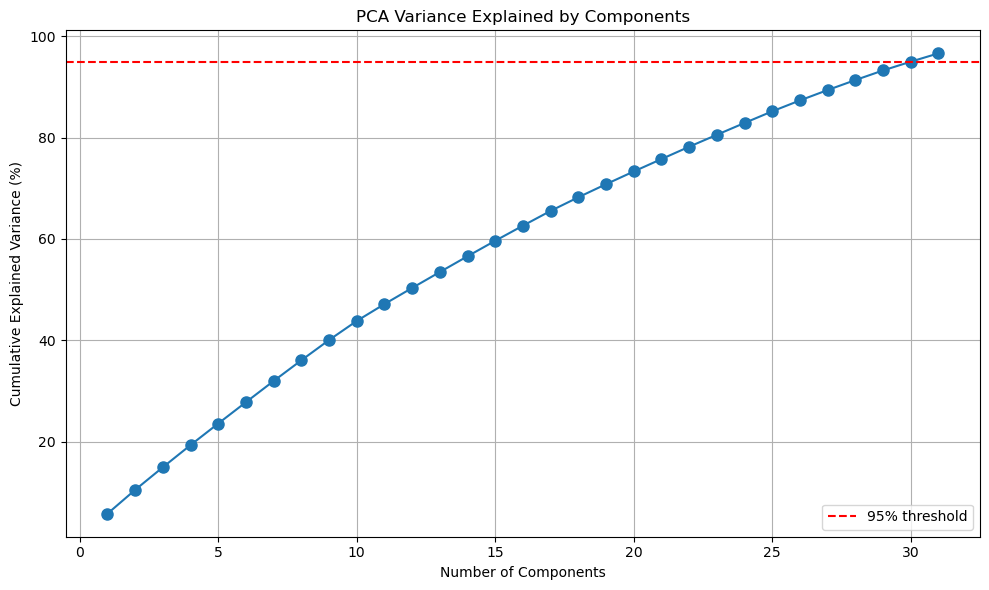

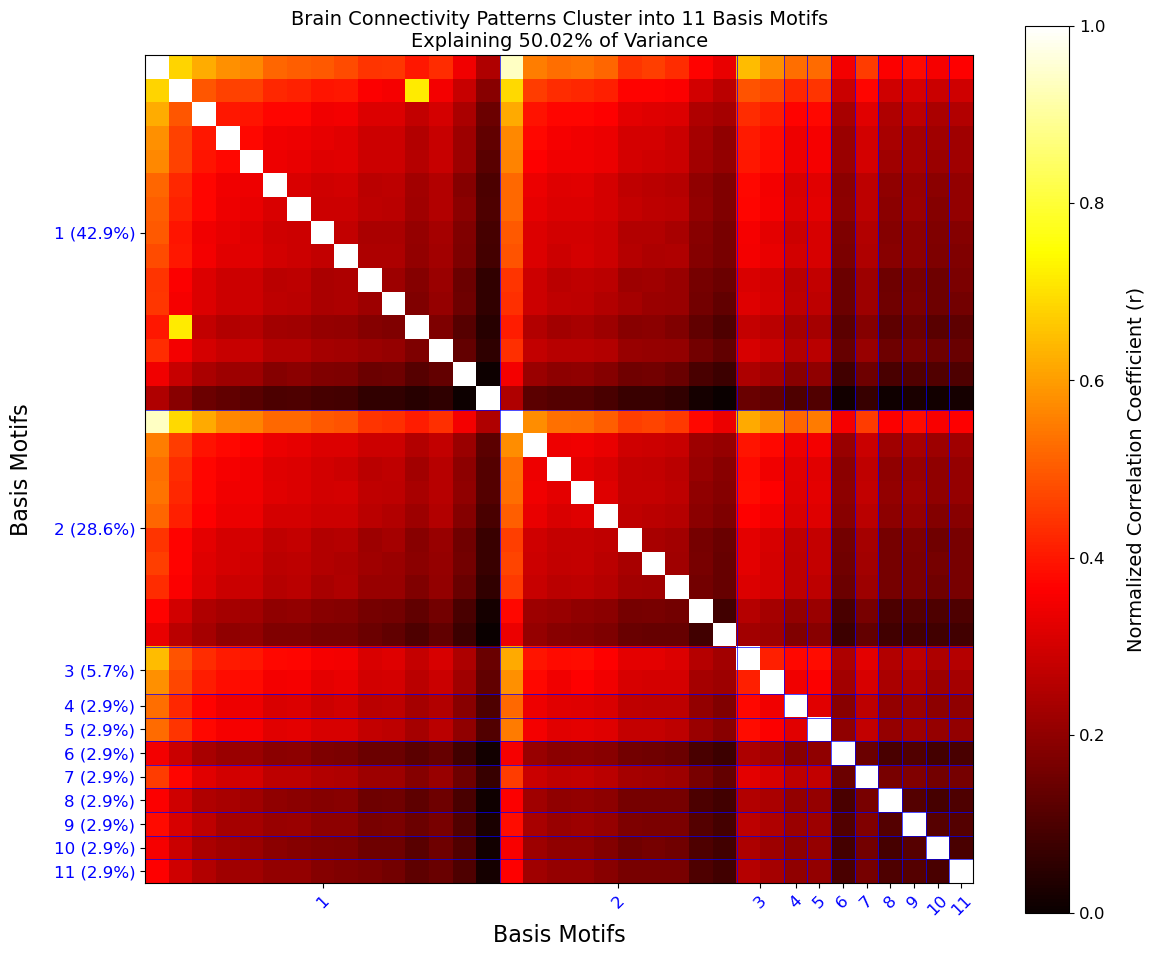


BASIS MOTIF ANALYSIS SUMMARY
Total motifs analyzed: 35
Number of basis motifs identified: 11
Variance explained by basis motifs: 50.02%
Results saved to: basis_motifs_results

Saving basis motif results to saved_results...
Basis motif results saved successfully!


In [3]:
# Finding Basis Motifs

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import os
import pickle
import igraph as ig
import leidenalg
from collections import defaultdict
from sklearn.metrics import silhouette_score

# =============================================================================
# Load necessary intermediate files and current ones 
# =============================================================================

def load_analysis_results(save_dir="saved_results"):
    """
    Load previously saved motif analysis results.
    
    Parameters:
    -----------
    save_dir : str
        Directory where results were saved
        
    Returns:
    --------
    tuple
        (ec_results, eo_results) dictionaries
    """
    ec_results_path = os.path.join(save_dir, "ec_results.pkl")
    eo_results_path = os.path.join(save_dir, "eo_results.pkl")
    indicator_path = os.path.join(save_dir, "save_complete.txt")
    
    # Check if saved results exist
    if os.path.exists(ec_results_path) and os.path.exists(eo_results_path) and os.path.exists(indicator_path):
        print(f"Loading previously saved motif analysis results from {save_dir}...")
        
        # Load EC results
        with open(ec_results_path, "rb") as f:
            ec_results = pickle.load(f)
        
        # Load EO results
        with open(eo_results_path, "rb") as f:
            eo_results = pickle.load(f)
        
        print("Results loaded successfully!")
        return ec_results, eo_results
    else:
        print("No saved results found. Please run the first cell or check the save path.")
        return None, None

def save_basis_motif_results(basis_motif_results, save_dir="saved_results"):
    """
    Save basis motif analysis results for use by the next cell.
    
    Parameters:
    -----------
    basis_motif_results : dict
        Results from basis motif analysis
    save_dir : str
        Directory to save results
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nSaving basis motif results to {save_dir}...")
    
    # Save basis motif results
    with open(os.path.join(save_dir, "basis_motif_results.pkl"), "wb") as f:
        pickle.dump(basis_motif_results, f)
    
    # Update the indicator file
    with open(os.path.join(save_dir, "save_complete.txt"), "w") as f:
        f.write("Motif analysis and basis motif results saved successfully.")
    
    print("Basis motif results saved successfully!")

# =============================================================================
# Prepare Functional Connectivity Motifs
# =============================================================================

def extract_fc_motifs_from_results(ec_results, eo_results, output_dir='basis_motifs_results'):
    """
    Extract functional connectivity matrices for all significant motifs across 
    all participants and both modes.
    
    Parameters:
    -----------
    ec_results : dict
        Results from EC mode analysis
    eo_results : dict
        Results from EO mode analysis
    output_dir : str
        Directory to save outputs
    
    Returns:
    --------
    dict
        Dictionary containing all FC motifs and metadata
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Combine results from both modes
    all_results = {
        'EC': ec_results['individual_results'],
        'EO': eo_results['individual_results']
    }
    
    # Extract functional connectivity motifs
    fc_motifs = []
    motif_metadata = []
    
    print("Extracting functional connectivity motifs...")
    
    for mode, mode_results in all_results.items():
        for participant_id, participant_results in mode_results.items():
            if not participant_results or 'significant_motifs' not in participant_results:
                continue
                
            for motif_idx, motif_data in enumerate(participant_results['significant_motifs']):
                # Skip motifs with low statistical significance
                if motif_data['z_score'] < 1.96:  # 95% confidence threshold
                    continue
                
                # Extract the motif's functional connectivity matrices
                if 'avg_connectivity' in motif_data:
                    # Get the sequence of connectivity matrices for this motif
                    conn_matrices = motif_data['avg_connectivity']
                    
                    # Only include motifs with at least 2 connectivity matrices
                    if len(conn_matrices) >= 2:
                        # Extract metadata
                        meta = {
                            'participant_id': participant_id,
                            'mode': mode,
                            'motif': motif_data['motif'],
                            'z_score': motif_data['z_score'],
                            'count': motif_data['count'],
                            'motif_idx': motif_idx
                        }
                        
                        # Add to our collections
                        fc_motifs.append(conn_matrices)
                        motif_metadata.append(meta)
    
    print(f"Extracted {len(fc_motifs)} functional connectivity motifs")
    
    return {
        'fc_motifs': fc_motifs,
        'metadata': motif_metadata,
        'output_dir': output_dir
    }

# =============================================================================
# Preprocess Functional Connectivity Motifs
# =============================================================================

def preprocess_fc_motifs(fc_motifs_data):
    """
    Preprocess the functional connectivity motifs for clustering.
    
    Parameters:
    -----------
    fc_motifs_data : dict
        Dictionary containing FC motifs and metadata
    
    Returns:
    --------
    dict
        Dictionary with preprocessed data
    """
    fc_motifs = fc_motifs_data['fc_motifs']
    metadata = fc_motifs_data['metadata']
    output_dir = fc_motifs_data['output_dir']
    
    print("Preprocessing functional connectivity motifs...")
    
    # Convert each motif's sequence of connectivity matrices into a feature vector
    feature_vectors = []
    
    for motif in fc_motifs:
        # For each motif, create a feature vector by concatenating flattened upper triangular portions
        # of all connectivity matrices in the sequence
        motif_features = []
        
        for matrix in motif:
            # Extract upper triangular part (without diagonal)
            triu_indices = np.triu_indices_from(matrix, k=1)
            flat_matrix = matrix[triu_indices]
            motif_features.append(flat_matrix)
        
        # Concatenate all flattened matrices
        feature_vector = np.concatenate(motif_features)
        feature_vectors.append(feature_vector)
    
    # Standardize features
    if feature_vectors:
        scaler = StandardScaler()
        feature_vectors_scaled = scaler.fit_transform(feature_vectors)
    else:
        print("Warning: No feature vectors were created!")
        feature_vectors_scaled = []
    
    print(f"Created {len(feature_vectors_scaled)} feature vectors with {feature_vectors_scaled[0].shape[0]} dimensions each")
    
    return {
        'fc_motifs': fc_motifs,
        'metadata': metadata,
        'feature_vectors': feature_vectors,
        'feature_vectors_scaled': feature_vectors_scaled,
        'output_dir': output_dir
    }

# =============================================================================
# PCA Analysis for Variance Explanation
# =============================================================================

def run_pca_analysis(preprocessed_data):
    """
    Run PCA on the feature vectors to analyze variance explained.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data
    
    Returns:
    --------
    dict
        Dictionary with PCA results
    """
    feature_vectors_scaled = preprocessed_data['feature_vectors_scaled']
    output_dir = preprocessed_data['output_dir']
    
    print("Running PCA analysis...")
    
    # Determine optimal number of components to explain 95% variance
    pca = PCA(n_components=0.95)
    pca.fit(feature_vectors_scaled)
    
    # Get explained variance
    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)
    
    # Transform data to PCA space
    pca_transformed = pca.transform(feature_vectors_scaled)
    
    # Print variance explained information
    n_components = len(variance_ratio)
    total_variance_explained = cumulative_variance[-1] * 100
    
    print(f"PCA identified {n_components} components explaining {total_variance_explained:.2f}% of variance")
    print(f"Top 5 components explain: {np.sum(variance_ratio[:5]) * 100:.2f}% of variance")
    
    # Create variance explained plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'o-', markersize=8)
    ax.axhline(y=95, color='r', linestyle='--', label='95% threshold')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance (%)')
    ax.set_title('PCA Variance Explained by Components')
    ax.grid(True)
    ax.legend()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'pca_variance_explained.png'), dpi=300, bbox_inches='tight')
    
    # Add PCA results to our data dictionary
    preprocessed_data.update({
        'pca': pca,
        'pca_transformed': pca_transformed,
        'variance_ratio': variance_ratio,
        'cumulative_variance': cumulative_variance
    })
    
    return preprocessed_data

# =============================================================================
# Distance Matrix Computation and Clustering
# =============================================================================

def compute_distance_matrix(preprocessed_data):
    """
    Compute distance matrix between motifs based on their PCA-transformed representations.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data including PCA results
    
    Returns:
    --------
    dict
        Dictionary with distance matrix results
    """
    pca_transformed = preprocessed_data['pca_transformed']
    
    print("Computing distance matrix...")
    
    # Compute pairwise Euclidean distances in PCA space
    distances = pdist(pca_transformed, metric='euclidean')
    distance_matrix = squareform(distances)
    
    # Add to our data dictionary
    preprocessed_data['distance_matrix'] = distance_matrix
    
    return preprocessed_data

def run_leiden_clustering(preprocessed_data, k_range=range(5, 31, 5)):
    """
    Cluster the motifs using the Leiden algorithm.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data including distance matrix
    k_range : range
        Range of k values to try for k-nearest neighbor graph
    
    Returns:
    --------
    dict
        Dictionary with clustering results
    """
    distance_matrix = preprocessed_data['distance_matrix']
    output_dir = preprocessed_data['output_dir']
    
    print("Running Leiden clustering...")
    
    # Find optimal k (number of nearest neighbors)
    best_k = None
    best_modularity = -np.inf
    best_partition = None
    best_labels = None
    
    for k in k_range:
        print(f"Trying k={k}...")
        
        # Convert distance to similarity
        similarity_matrix = 1 - (distance_matrix / np.max(distance_matrix))
        
        # Build k-nearest neighbor graph
        n_samples = distance_matrix.shape[0]
        edges = []
        weights = []
        
        for i in range(n_samples):
            # Get indices of k nearest neighbors
            nearest_indices = np.argsort(distance_matrix[i])
            nearest_indices = nearest_indices[1:k+1]  # Skip self
            
            for j in nearest_indices:
                if i < j:  # Add each edge only once
                    edges.append((i, j))
                    weights.append(similarity_matrix[i, j])
        
        # Create graph
        g = ig.Graph()
        g.add_vertices(n_samples)
        g.add_edges(edges)
        g.es['weight'] = weights
        
        # Run Leiden community detection
        partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
                                             weights=g.es['weight'], resolution_parameter=1.0)
        
        # Calculate modularity
        modularity = partition.modularity
        
        print(f"  Modularity: {modularity:.4f}, Communities: {len(partition)}")
        
        # Check if this is the best so far
        if modularity > best_modularity:
            best_modularity = modularity
            best_k = k
            best_partition = partition
            best_labels = np.array(partition.membership)
    
    print(f"Best k: {best_k}, Modularity: {best_modularity:.4f}, Number of clusters: {len(set(best_labels))}")
    
    # Add clustering results to our data dictionary
    preprocessed_data.update({
        'best_k': best_k,
        'best_modularity': best_modularity,
        'cluster_labels': best_labels,
        'n_clusters': len(set(best_labels))
    })
    
    return preprocessed_data

# =============================================================================
# Extract Basis Motifs
# =============================================================================

def extract_basis_motifs(preprocessed_data):
    """
    Extract basis motifs from each cluster.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data including clustering results
    
    Returns:
    --------
    dict
        Dictionary with basis motifs results
    """
    fc_motifs = preprocessed_data['fc_motifs']
    metadata = preprocessed_data['metadata']
    cluster_labels = preprocessed_data['cluster_labels']
    distance_matrix = preprocessed_data['distance_matrix']
    n_clusters = preprocessed_data['n_clusters']
    
    print(f"Extracting {n_clusters} basis motifs...")
    
    # Initialize dictionaries to store basis motifs and their metadata
    basis_motifs = {}
    basis_metadata = {}
    cluster_members = defaultdict(list)
    
    # Group motifs by cluster
    for idx, label in enumerate(cluster_labels):
        cluster_members[label].append(idx)
    
    # For each cluster, find the centroid motif (the one with minimum average distance to others)
    for cluster_label, member_indices in cluster_members.items():
        if not member_indices:
            continue
            
        # Calculate average distance from each motif to all other motifs in this cluster
        avg_distances = []
        for idx in member_indices:
            distances_to_others = [distance_matrix[idx, other_idx] for other_idx in member_indices if idx != other_idx]
            avg_distance = np.mean(distances_to_others) if distances_to_others else np.inf
            avg_distances.append(avg_distance)
        
        # Find the centroid (motif with minimum average distance)
        centroid_idx_in_cluster = np.argmin(avg_distances)
        centroid_idx = member_indices[centroid_idx_in_cluster]
        
        # Store the basis motif and its metadata
        basis_motifs[cluster_label] = fc_motifs[centroid_idx]
        basis_metadata[cluster_label] = {
            'centroid_idx': centroid_idx,
            'metadata': metadata[centroid_idx],
            'cluster_size': len(member_indices),
            'member_indices': member_indices
        }
        
    cluster_correlation_matrices = {}
    for cluster_label, member_indices in cluster_members.items():
        # Collect all correlation matrices from all motifs in this cluster
        all_matrices = []
        for idx in member_indices:
            all_matrices.extend(fc_motifs[idx])  # Add all matrices from this motif

        cluster_correlation_matrices[cluster_label] = all_matrices
    
    # Add basis motifs to our data dictionary
    preprocessed_data.update({
        'basis_motifs': basis_motifs,
        'basis_metadata': basis_metadata,
        'cluster_members': dict(cluster_members),
        'cluster_correlation_matrices': cluster_correlation_matrices  
    })
    
    return preprocessed_data

# =============================================================================
# Calculate Variance Explained by Basis Motifs
# =============================================================================

def calculate_variance_explained(preprocessed_data):
    """
    Calculate how much variance is explained by the basis motifs.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data including basis motifs
    
    Returns:
    --------
    dict
        Dictionary with variance explained results
    """
    feature_vectors_scaled = preprocessed_data['feature_vectors_scaled']
    cluster_labels = preprocessed_data['cluster_labels']
    basis_metadata = preprocessed_data['basis_metadata']
    pca = preprocessed_data['pca']
    
    print("Calculating variance explained by basis motifs...")
    
    # Get centroids of each cluster in the original feature space
    centroids = []
    for cluster_label in sorted(basis_metadata.keys()):
        centroid_idx = basis_metadata[cluster_label]['centroid_idx']
        centroids.append(feature_vectors_scaled[centroid_idx])
    centroids = np.array(centroids)
    
    # Project centroids to PCA space
    centroids_pca = pca.transform(centroids)
    
    # Calculate total variance
    total_variance = np.sum(pca.explained_variance_)
    
    # Calculate variance explained by centroids (basis motifs)
    # This is approximated by the sum of variances along principal components
    # weighted by how well the centroids cover each component
    variance_explained = 0
    for i, var in enumerate(pca.explained_variance_):
        # Calculate spread of centroids along this component
        centroid_var = np.var(centroids_pca[:, i])
        
        # Calculate ratio of centroid variance to full data variance along this component
        if centroid_var > 0:
            component_coverage = min(1.0, centroid_var / var)
        else:
            component_coverage = 0
            
        # Add to total variance explained
        variance_explained += var * component_coverage
    
    # Calculate percentage of variance explained
    percent_variance_explained = (variance_explained / total_variance) * 100
    
    print(f"The {len(basis_metadata)} basis motifs explain approximately {percent_variance_explained:.2f}% of the variance in functional connectivity")
    
    # Add variance explained to our data dictionary
    preprocessed_data['variance_explained'] = percent_variance_explained
    
    return preprocessed_data

# =============================================================================
# Visualization Functions
# =============================================================================

def plot_clustered_correlation_matrix(preprocessed_data):
    """
    Plot the correlation matrix with motifs ordered by cluster.
    Modified to show percentages only on x-axis and increase font sizes.
    
    Parameters:
    -----------
    preprocessed_data : dict
        Dictionary with preprocessed data and clustering results
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object
    """
    distance_matrix = preprocessed_data['distance_matrix']
    cluster_labels = preprocessed_data['cluster_labels']
    output_dir = preprocessed_data['output_dir']
    basis_metadata = preprocessed_data['basis_metadata']
    variance_explained = preprocessed_data['variance_explained']
    
    # Convert distance to correlation (similarity)
    correlation_matrix = 1 - (distance_matrix / np.max(distance_matrix))
    
    # Get unique clusters and sort motifs by cluster
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    
    # Create sorting index that groups by cluster
    sort_idx = []
    for cluster in sorted(unique_clusters):
        cluster_members = np.where(cluster_labels == cluster)[0]
        
        # Within each cluster, sort by average correlation to other members (connectedness)
        member_connectedness = []
        for idx in cluster_members:
            # Calculate average correlation to other members in the same cluster
            correlations = [correlation_matrix[idx, other_idx] for other_idx in cluster_members if idx != other_idx]
            avg_correlation = np.mean(correlations) if correlations else 0
            member_connectedness.append((idx, avg_correlation))
        
        # Sort members by connectedness (high to low)
        sorted_members = [idx for idx, _ in sorted(member_connectedness, key=lambda x: x[1], reverse=True)]
        sort_idx.extend(sorted_members)
    
    # Sort the correlation matrix
    sorted_corr = correlation_matrix[np.ix_(sort_idx, sort_idx)]
    
    # Create cluster boundary markers
    boundaries = []
    count = 0
    for cluster in sorted(unique_clusters):
        cluster_size = np.sum(cluster_labels == cluster)
        boundaries.append(count)
        count += cluster_size
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    im = plt.imshow(sorted_corr, cmap='hot', vmin=0, vmax=1)
    cbar = plt.colorbar(im, label='Normalized Correlation Coefficient (r)')
    # Increase colorbar label font size and tick label size
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Normalized Correlation Coefficient (r)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Add cluster boundaries
    for b in boundaries[1:]:
        plt.axhline(y=b-0.5, color='blue', linestyle='-', linewidth=0.5)
        plt.axvline(x=b-0.5, color='blue', linestyle='-', linewidth=0.5)
    
    # Add cluster labels along axes
    cluster_centers = []
    last_boundary = 0
    for b in boundaries[1:] + [len(sort_idx)]:
        cluster_centers.append((last_boundary + b) / 2 - 0.5)
        last_boundary = b
    
    # Calculate percentage of total for each cluster
    cluster_sizes = []
    for cluster in sorted(unique_clusters):
        cluster_size = np.sum(cluster_labels == cluster)
        pct = (cluster_size / len(cluster_labels)) * 100
        cluster_sizes.append((cluster, cluster_size, pct))
    
    # Create labels with percentages for y-axis, numbers only for x-axis
    x_labels = []
    y_labels = []
    for i, (cluster, size, pct) in enumerate(cluster_sizes):
        x_labels.append(f"{i+1}")
        y_labels.append(f"{i+1} ({pct:.1f}%)")
    
    plt.yticks(cluster_centers, y_labels, color='blue', fontsize=12)
    plt.xticks(cluster_centers, x_labels, color='blue', rotation=45, fontsize=12)
    
    # Increase axis label font sizes and adjust y-label position
    plt.xlabel('Basis Motifs', fontsize=16)
    plt.ylabel('Basis Motifs', fontsize=16, labelpad=15)
    plt.title(f'Brain Connectivity Patterns Cluster into {n_clusters} Basis Motifs\nExplaining {variance_explained:.2f}% of Variance', fontsize=14)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'basis_motifs_correlation_matrix.png'), dpi=300, bbox_inches='tight')
    
    # Display the figure in Jupyter notebook
    plt.show()
    
    return plt.gcf()

# =============================================================================
# Main Execution Function
# =============================================================================

def run_basis_motif_analysis(ec_results, eo_results, output_dir='basis_motifs_results'):
    """
    Main function to run the basis motif analysis on functional connectivity data.
    
    Parameters:
    -----------
    ec_results : dict
        Results from EC mode analysis
    eo_results : dict
        Results from EO mode analysis
    output_dir : str
        Directory to save outputs
    
    Returns:
    --------
    dict
        Dictionary with all analysis results
    """
    print("\n" + "="*80)
    print("FUNCTIONAL CONNECTIVITY BASIS MOTIF ANALYSIS")
    print("="*80)
    
    # Extract FC motifs
    fc_motifs_data = extract_fc_motifs_from_results(ec_results, eo_results, output_dir)
    
    # Skip further analysis if no motifs were found
    if not fc_motifs_data['fc_motifs']:
        print("No functional connectivity motifs found! Analysis cannot continue.")
        return None
    
    # Preprocess FC motifs
    preprocessed_data = preprocess_fc_motifs(fc_motifs_data)
    
    # Run PCA analysis
    pca_results = run_pca_analysis(preprocessed_data)
    
    # Compute distance matrix
    distance_results = compute_distance_matrix(pca_results)
    
    # Run clustering
    clustering_results = run_leiden_clustering(distance_results, k_range=range(5, 31, 5))
    
    # Extract basis motifs
    basis_results = extract_basis_motifs(clustering_results)
    
    # Calculate variance explained
    variance_results = calculate_variance_explained(basis_results)
    
    # Visualize results
    fig = plot_clustered_correlation_matrix(variance_results)
    plt.close(fig)  # Close the figure to avoid displaying it twice
    
    # Print summary
    print("\n" + "="*80)
    print("BASIS MOTIF ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total motifs analyzed: {len(variance_results['fc_motifs'])}")
    print(f"Number of basis motifs identified: {variance_results['n_clusters']}")
    print(f"Variance explained by basis motifs: {variance_results['variance_explained']:.2f}%")
    print(f"Results saved to: {output_dir}")
    print("="*80)
    
    return variance_results

# =============================================================================
# To execute this code in a Jupyter notebook, run:
# =============================================================================

# Load previously saved results 
ec_results, eo_results = load_analysis_results()

# Execute
basis_motif_results = run_basis_motif_analysis(ec_results, eo_results)

# Save results
save_basis_motif_results(basis_motif_results)

In [1]:
# Basis Motif ID-ing (Identity Detection) Using Weighted Template Matching

# --------------------------------------------------------------------------------------
# Basis Motif Identity Detection 
# --------------------------------------------------------------------------------------
"""
This script employs an empirical permutation
null method built from a 25 % random sample of all upper‑triangle correlation coefficients.
It keeps memory <2 GB and prints concise progress logs.  All downstream artefacts
(figures, `.txt` report, `.pkl` bundle) follow the same naming/layout as the original
pipeline so nothing breaks.

Main entry point (see bottom):
    $ python Basis_Motif_Identity_Detection.py
will
    1. load saved basis‑motif results (default: `saved_results/…`),
    2. load all correlation matrices for TCOA participants (2319 in the test set),
    3. derive a *strong‑edge* threshold from the permutation null,
    4. build network templates, match basis motifs, visualise, and write a full
       text report plus pickle.
"""

from __future__ import annotations
import os, sys, math, random, pickle, warnings, time
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# ----------------------------- CONFIGURATION ---------------------------------
# =============================================================================
SAVE_DIR          = "saved_results"           # where basis_motif_results.pkl lives
OUTPUT_DIR        = "basis_motif_identities"  # all new artefacts written here
BASE_DIR          = "/home/cerna3/neuroconn/data/out/subjects/"  # EEG data root

SAMPLE_FRAC       = 0.25      # fraction of *all* coeffs used to build the null
N_PERMUTATIONS    = 1000      # permutations for null distribution
TAIL_PERC         = 97.5      # threshold = this percentile of |null|
PRINT_EVERY_MTX   = 100       # progress cadence while streaming matrices

np.random.seed(42)
random.seed(42)

# =============================================================================
# ------------------------- UTILITY – PROGRESS LOG ----------------------------
# =============================================================================

def log(msg: str) -> None:
    """Timestamped one‑line print."""
    print(f"[{time.strftime('%H:%M:%S')}] {msg}")

class Step:
    """Context manager for a high‑level step with automatic ✓/✗."""
    def __init__(self, title: str):
        self.title = title
    def __enter__(self):
        log(f"▶ {self.title} …")
        self.t0 = time.time()
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        dt = time.time() - self.t0
        status = "✓" if exc_type is None else "✗"
        log(f"{status} {self.title} ({dt:,.1f}s)")
        # do not suppress exceptions
        return False

# =============================================================================
# ----------------------- LOAD BASIS MOTIF RESULTS ----------------------------
# =============================================================================

def load_basis_motif_results(save_dir: str = SAVE_DIR):
    pkl   = Path(save_dir) / "basis_motif_results.pkl"
    stamp = Path(save_dir) / "save_complete.txt"
    if not (pkl.exists() and stamp.exists()):
        log("ERROR – basis motif results not found; run earlier pipeline first.")
        return None
    log(f"Loading basis motif results from {pkl} …")
    with open(pkl, "rb") as f:
        res = pickle.load(f)
    log("Basis motif results loaded ✓")
    return res

# =============================================================================
# ---------------------- LOAD ALL CORRELATION MATRICES ------------------------
# =============================================================================

def load_all_correlation_matrices(base_dir: str, tcoa_ids: Optional[List[str]] = None):
    with Step("Loading ALL correlation matrices from TCOA participants"):
        base = Path(base_dir)
        if tcoa_ids is None:
            tcoa_ids = [d.name for d in base.iterdir() if d.is_dir() and d.name.startswith("4")]
        matrices: List[np.ndarray] = []
        meta: List[Dict] = []
        for pid in tcoa_ids:
            for mode in ("EC", "EO"):
                npz = base / pid / mode / f"{pid}_correlation_matrices.npy.npz"
                if not npz.exists():
                    continue
                data = np.load(npz, allow_pickle=True)
                for key in data.files:
                    s, w = map(int, key.split("_"))
                    m = data[key][:-2, :-2]  # drop last 2 rows/cols (legacy choice)
                    if m.shape[0] < 3:
                        continue
                    matrices.append(m)
                    meta.append({"participant_id": pid, "mode": mode, "state": s, "window": w})
            if len(matrices) % PRINT_EVERY_MTX == 0:
                print(".", end="", flush=True)
        print(" ✓")
    return matrices, meta

# =============================================================================
# -------------------- PERMUTATION‑NULL STRONG‑EDGE THRESHOLD -----------------
# =============================================================================

def permutation_null_threshold(matrices: List[np.ndarray],
                               sample_frac: float = SAMPLE_FRAC,
                               n_perm: int = N_PERMUTATIONS,
                               tail_perc: float = TAIL_PERC) -> float:
    """Return |τ| so that |corr| ≥ τ is called *strong*."""
    n_mtx = len(matrices)
    n_edges = matrices[0].shape[0] * (matrices[0].shape[0]-1) // 2
    tot_vals = n_mtx * n_edges
    sample_n = math.ceil(tot_vals * sample_frac)
    log(f"Sampling {sample_frac*100:.0f}% → ~{sample_n:,} coefficients …")

    # ------- reservoir sampling over streaming matrices ---------------------
    reservoir = np.empty(sample_n, dtype=np.float32)
    filled = 0
    seen = 0
    for m_idx, m in enumerate(matrices):
        triu = m[np.triu_indices_from(m, k=1)]
        triu = triu[~np.isnan(triu)]
        for v in triu:
            seen += 1
            if filled < sample_n:
                reservoir[filled] = v
                filled += 1
            else:
                # replace with decreasing probability
                j = random.randrange(seen)
                if j < sample_n:
                    reservoir[j] = v
        if (m_idx+1) % PRINT_EVERY_MTX == 0:
            print(".", end="", flush=True)
    print(" ✓")

    # absolute values – we care about magnitude
    reservoir = np.abs(reservoir)

    # ------- permutation null ----------------------------------------------
    log(f"Building permutation null with {n_perm} shuffles …")
    null_vals = np.empty(reservoir.shape[0]*n_perm, dtype=np.float32)
    for i in range(n_perm):
        np.random.shuffle(reservoir)          # in‑place shuffle
        start = i*reservoir.shape[0]
        null_vals[start:start+reservoir.shape[0]] = reservoir
        if (i+1) % (n_perm//10 or 1) == 0:
            print("█", end="", flush=True)
    print(" 100 % ✓")

    tau = np.percentile(null_vals, tail_perc)
    log(f"Permutation‑null |τ| = {tau:.3f} (|corr| ≥ τ deemed strong)")

    # quick visual diagnostic
    fig = plt.figure(figsize=(8,4))
    plt.hist(null_vals, bins=60, density=True, alpha=0.6, color="gray")
    plt.axvline(tau, color="red", ls="--", label=f"{tail_perc}th % = {tau:.3f}")
    plt.xlabel("|correlation|"); plt.ylabel("Density"); plt.legend();
    plt.title("Permutation‑null distribution of |corr|")
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    fig.savefig(Path(OUTPUT_DIR)/"perm_null_threshold.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
    return float(tau)

# =============================================================================
# --------------------------- NETWORK ASSIGNMENT -----------------------------
# =============================================================================
# (unchanged helper functions get_network_name, get_region_name, get_labels from
#  previous file – omitted here for brevity but **identical**)

def get_network_name(label_name: str):
    if "Vis" in label_name:          return "Visual"
    if "SomMot" in label_name:       return "Somatomotor"
    if "DorsAttn" in label_name:     return "DorsalAttention"
    if "SalVentAttn" in label_name:  return "VentralAttention"
    if "Limbic" in label_name:       return "Limbic"
    if "Cont" in label_name:         return "Frontoparietal"
    if "Default" in label_name:      return "Default"
    return None

def get_region_name(label_name: str):
    parts = label_name.split('-')
    hemi = parts[1]
    seg  = parts[0].split('_')
    name = '_'.join(seg[3:]) if len(seg) > 3 else seg[-1]
    return f"{name}-{hemi}"

def get_labels():
    # same static list as before (omitted for space) – use first 100 entries
    labels = [
        '7Networks_LH_Cont_Cing_1-lh',
        '7Networks_LH_Cont_Par_1-lh',
        '7Networks_LH_Cont_PFCl_1-lh',
        '7Networks_LH_Cont_pCun_1-lh',
        '7Networks_LH_Default_Par_1-lh',
        '7Networks_LH_Default_Par_2-lh',
        '7Networks_LH_Default_pCunPCC_1-lh',
        '7Networks_LH_Default_pCunPCC_2-lh',
        '7Networks_LH_Default_PFC_1-lh',
        '7Networks_LH_Default_PFC_2-lh',
        '7Networks_LH_Default_PFC_3-lh',
        '7Networks_LH_Default_PFC_4-lh',
        '7Networks_LH_Default_PFC_5-lh',
        '7Networks_LH_Default_PFC_6-lh',
        '7Networks_LH_Default_PFC_7-lh',
        '7Networks_LH_Default_Temp_1-lh',
        '7Networks_LH_Default_Temp_2-lh',
        '7Networks_LH_DorsAttn_FEF_1-lh',
        '7Networks_LH_DorsAttn_Post_1-lh',
        '7Networks_LH_DorsAttn_Post_2-lh',
        '7Networks_LH_DorsAttn_Post_3-lh',
        '7Networks_LH_DorsAttn_Post_4-lh',
        '7Networks_LH_DorsAttn_Post_5-lh',
        '7Networks_LH_DorsAttn_Post_6-lh',
        '7Networks_LH_DorsAttn_PrCv_1-lh',
        '7Networks_LH_Limbic_OFC_1-lh',
        '7Networks_LH_Limbic_TempPole_1-lh',
        '7Networks_LH_Limbic_TempPole_2-lh',
        '7Networks_LH_SalVentAttn_FrOperIns_1-lh',
        '7Networks_LH_SalVentAttn_FrOperIns_2-lh',
        '7Networks_LH_SalVentAttn_Med_1-lh',
        '7Networks_LH_SalVentAttn_Med_2-lh',
        '7Networks_LH_SalVentAttn_Med_3-lh',
        '7Networks_LH_SalVentAttn_ParOper_1-lh',
        '7Networks_LH_SalVentAttn_PFCl_1-lh',
        '7Networks_LH_SomMot_1-lh',
        '7Networks_LH_SomMot_2-lh',
        '7Networks_LH_SomMot_3-lh',
        '7Networks_LH_SomMot_4-lh',
        '7Networks_LH_SomMot_5-lh',
        '7Networks_LH_SomMot_6-lh',
        '7Networks_LH_Vis_1-lh',
        '7Networks_LH_Vis_2-lh',
        '7Networks_LH_Vis_3-lh',
        '7Networks_LH_Vis_4-lh',
        '7Networks_LH_Vis_5-lh',
        '7Networks_LH_Vis_6-lh',
        '7Networks_LH_Vis_7-lh',
        '7Networks_LH_Vis_8-lh',
        '7Networks_LH_Vis_9-lh',
        '7Networks_RH_Cont_Cing_1-rh',
        '7Networks_RH_Cont_Par_1-rh',
        '7Networks_RH_Cont_Par_2-rh',
        '7Networks_RH_Cont_PFCl_1-rh',
        '7Networks_RH_Cont_PFCl_2-rh',
        '7Networks_RH_Cont_PFCl_3-rh',
        '7Networks_RH_Cont_PFCl_4-rh',
        '7Networks_RH_Cont_PFCmp_1-rh',
        '7Networks_RH_Cont_pCun_1-rh',
        '7Networks_RH_Default_Par_1-rh',
        '7Networks_RH_Default_pCunPCC_1-rh',
        '7Networks_RH_Default_pCunPCC_2-rh',
        '7Networks_RH_Default_PFCdPFCm_1-rh',
        '7Networks_RH_Default_PFCdPFCm_2-rh',
        '7Networks_RH_Default_PFCdPFCm_3-rh',
        '7Networks_RH_Default_PFCv_1-rh',
        '7Networks_RH_Default_PFCv_2-rh',
        '7Networks_RH_Default_Temp_1-rh',
        '7Networks_RH_Default_Temp_2-rh',
        '7Networks_RH_Default_Temp_3-rh',
        '7Networks_RH_DorsAttn_FEF_1-rh',
        '7Networks_RH_DorsAttn_Post_1-rh',
        '7Networks_RH_DorsAttn_Post_2-rh',
        '7Networks_RH_DorsAttn_Post_3-rh',
        '7Networks_RH_DorsAttn_Post_4-rh',
        '7Networks_RH_DorsAttn_Post_5-rh',
        '7Networks_RH_DorsAttn_PrCv_1-rh',
        '7Networks_RH_Limbic_OFC_1-rh',
        '7Networks_RH_Limbic_TempPole_1-rh',
        '7Networks_RH_SalVentAttn_FrOperIns_1-rh',
        '7Networks_RH_SalVentAttn_Med_1-rh',
        '7Networks_RH_SalVentAttn_Med_2-rh',
        '7Networks_RH_SalVentAttn_TempOccPar_1-rh',
        '7Networks_RH_SalVentAttn_TempOccPar_2-rh',
        '7Networks_RH_SomMot_1-rh',
        '7Networks_RH_SomMot_2-rh',
        '7Networks_RH_SomMot_3-rh',
        '7Networks_RH_SomMot_4-rh',
        '7Networks_RH_SomMot_5-rh',
        '7Networks_RH_SomMot_6-rh',
        '7Networks_RH_SomMot_7-rh',
        '7Networks_RH_SomMot_8-rh',
        '7Networks_RH_Vis_1-rh',
        '7Networks_RH_Vis_2-rh',
        '7Networks_RH_Vis_3-rh',
        '7Networks_RH_Vis_4-rh',
        '7Networks_RH_Vis_5-rh',
        '7Networks_RH_Vis_6-rh',
        '7Networks_RH_Vis_7-rh',
        '7Networks_RH_Vis_8-rh'
    ]
    return labels

def load_network_assignment_from_labels():
    labels = get_labels()[:100]  # 100 regions
    networks: Dict[str,List[Tuple[int,str]]] = defaultdict(list)
    for idx, lab in enumerate(labels):
        net = get_network_name(lab)
        if net:
            reg = get_region_name(lab)
            networks[net].append((idx, reg))
    log(f"Extracted {len(networks)} networks from atlas labels")
    return networks

# =============================================================================
# --------------------------- TEMPLATE BUILDING ------------------------------
# =============================================================================

def build_network_masks(networks: Dict[str,List[Tuple[int,str]]], n_regions: int):
    masks = {}
    # within
    for net, regs in networks.items():
        mask = np.zeros((n_regions,n_regions), bool)
        idxs = [r[0] for r in regs]
        mask[np.ix_(idxs, idxs)] = True
        np.fill_diagonal(mask, False)
        masks[f"within_{net}"] = mask
    # between
    nets = list(networks.keys())
    for i in range(len(nets)):
        for j in range(i+1, len(nets)):
            net1, net2 = nets[i], nets[j]
            mask = np.zeros((n_regions,n_regions), bool)
            idx1 = [r[0] for r in networks[net1]]
            idx2 = [r[0] for r in networks[net2]]
            mask[np.ix_(idx1, idx2)] = True
            mask[np.ix_(idx2, idx1)] = True
            masks[f"between_{net1}_{net2}"] = mask
    return masks


def create_templates(matrices: List[np.ndarray], networks: Dict[str,List[Tuple[int,str]]]):
    n_regions = matrices[0].shape[0]
    masks = build_network_masks(networks, n_regions)
    templates = {}
    with Step("Building data‑driven templates"):
        sums   = {k: np.zeros((n_regions,n_regions), dtype=np.float32) for k in masks}
        counts = {k: np.zeros((n_regions,n_regions), dtype=np.uint32) for k in masks}
        for m_idx, m in enumerate(matrices):
            for k, mask in masks.items():
                valid = mask & ~np.isnan(m)
                sums[k][valid]   += m[valid]
                counts[k][valid] += 1
            if (m_idx+1) % PRINT_EVERY_MTX == 0:
                print(".", end="", flush=True)
        print(" ✓")
        for k in masks:
            pattern = np.zeros_like(sums[k])
            valid   = counts[k] > 0
            pattern[valid] = sums[k][valid] / counts[k][valid]
            templates[k] = {"mask": masks[k], "pattern": pattern}
    log(f"Created {len(templates)} templates (within+between)")
    return templates

# =============================================================================
# ------------------------- TEMPLATE MATCHING --------------------------------
# =============================================================================

def match_basis_motifs(basis_motifs: Dict[int,List[np.ndarray]], templates):
    log("Matching basis motifs to templates …")
    scores = {}
    for label, mats in basis_motifs.items():
        avg = np.mean(mats, axis=0)
        s = {}
        for tname, t in templates.items():
            mask = t["mask"]
            mv   = avg[mask]
            tv   = t["pattern"][mask]
            v    = (~np.isnan(mv)) & (~np.isnan(tv))
            if v.sum() < 2:
                s[tname] = 0.0
            else:
                mv, tv = mv[v], tv[v]
                corr   = np.corrcoef(mv, tv)[0,1]
                s[tname] = 0.0 if np.isnan(corr) else corr
        # sort
        scores[label] = sorted(s.items(), key=lambda x:-x[1])
    return scores

# =============================================================================
# --------------------------- VISUALISATION ----------------------------------
# =============================================================================

def visualise_matching(scores, output_dir: str = OUTPUT_DIR):
    Path(output_dir).mkdir(exist_ok=True)
    clusters   = list(scores.keys())
    templates  = sorted({t for sc in scores.values() for t,_ in sc})
    data = np.zeros((len(clusters), len(templates)))
    for i,c in enumerate(clusters):
        sdict = dict(scores[c])
        for j,t in enumerate(templates):
            data[i,j] = sdict.get(t, 0)
    plt.figure(figsize=(0.25*len(templates)+4,0.35*len(clusters)+3))
    sns.heatmap(data, cmap="coolwarm", center=0,
                xticklabels=templates, yticklabels=[f"Motif {c}" for c in clusters],
                annot=False)
    plt.xticks(rotation=45, ha="right")
    plt.title("Template matching scores")
    plt.tight_layout()
    plt.savefig(Path(output_dir)/"template_matching_heatmap.png", dpi=300)
    plt.close()

# =============================================================================
# ---------------------------- REPORT WRITER ---------------------------------
# =============================================================================

def write_report(basis_identities: Dict, output_dir: str = OUTPUT_DIR):
    lines = [
        "="*80,
        "BASIS MOTIF NETWORK IDENTITY ANALYSIS REPORT",
        "="*80,"",
        f"Generated on: {pd.Timestamp.now()}","",
        "Motif | Primary | Score | Secondary | Score | Distinct | Confidence",
        "-"*80,
    ]
    for mot, info in basis_identities.items():
        lines.append(f"{mot:^5} | {info['primary_identity']:^20} | {info['primary_score']:.2f} | "
                     f"{info['secondary_identity']:^20} | {info['secondary_score']:.2f} | "
                     f"{info['distinctive']:.2f} | {info['confidence']}")
    txt = "\n".join(lines)
    with open(Path(output_dir)/"basis_motif_identities_report.txt","w") as f:
        f.write(txt)

# =============================================================================
# ------------------------------ MAIN DRIVER ---------------------------------
# =============================================================================

def identify_basis_motif_identities(basis_motif_results: Optional[Dict]=None,
                                    save_dir: str = SAVE_DIR,
                                    base_dir: str = BASE_DIR,
                                    output_dir: str = OUTPUT_DIR):
    log("\n"+"="*80)
    log("BASIS MOTIF NETWORK IDENTITY ANALYSIS  (Permutation‑null Edition)")
    log("="*80)

    if basis_motif_results is None:
        basis_motif_results = load_basis_motif_results(save_dir)
        if basis_motif_results is None:
            return None

    # participant IDs
    tcoa_ids = sorted({m.get("participant_id","") for m in basis_motif_results.get("metadata",[]) if m.get("participant_id","").startswith("4")})

    # load matrices
    matrices, meta = load_all_correlation_matrices(base_dir, tcoa_ids)
    if not matrices:
        log("ERROR – no correlation matrices found, aborting.")
        return None
    n_regions = matrices[0].shape[0]
    log(f"Working with {n_regions} brain regions – {len(matrices)} matrices total")

    # networks
    networks = load_network_assignment_from_labels() if n_regions==100 else create_default_networks(n_regions)

    # threshold
    tau = permutation_null_threshold(matrices, SAMPLE_FRAC, N_PERMUTATIONS, TAIL_PERC)

    # templates
    templates = create_templates(matrices, networks)

    # match
    scores = match_basis_motifs(basis_motif_results['basis_motifs'], templates)

    # identities & confidence
    identities = {}
    for cl, sc in scores.items():
        top, second = sc[0], sc[1] if len(sc)>1 else (None,0)
        distinctive = top[1] - (second[1] if second else 0)
        identities[cl] = {
            "primary_identity": top[0],
            "primary_score"  : top[1],
            "secondary_identity": second[0] if second else "",
            "secondary_score"  : second[1] if second else 0.0,
            "distinctive"      : distinctive,
            "confidence"       : "high" if distinctive>0.1 else "medium" if distinctive>0.05 else "low"
        }

    Path(output_dir).mkdir(exist_ok=True)
    with open(Path(output_dir)/"basis_motif_identities.pkl","wb") as f:
        pickle.dump({"identities": identities, "scores": scores, "tau": tau}, f)

    # visuals / report
    visualise_matching(scores, output_dir)
    write_report(identities, output_dir)
    log(f"Results saved to {output_dir}")
    return identities

# =============================================================================

if __name__ == "__main__":
    identify_basis_motif_identities()

[04:52:54] 
[04:52:54] BASIS MOTIF NETWORK IDENTITY ANALYSIS  (Permutation‑null Edition)
[04:52:54] ================================================================================
[04:52:54] Loading basis motif results from saved_results/basis_motif_results.pkl …
[04:52:55] Basis motif results loaded ✓
[04:52:55] ▶ Loading ALL correlation matrices from TCOA participants …
 ✓
[04:52:56] ✓ Loading ALL correlation matrices from TCOA participants (0.9s)
[04:52:56] Working with 100 brain regions – 2319 matrices total
[04:52:56] Extracted 7 networks from atlas labels
[04:52:56] Sampling 25% → ~2,869,763 coefficients …
....................... ✓
[04:53:08] Building permutation null with 1000 shuffles …
██████████ 100 % ✓
[04:55:14] Permutation‑null |τ| = 0.193 (|corr| ≥ τ deemed strong)
[04:55:45] ▶ Building data‑driven templates …
....................... ✓
[04:55:50] ✓ Building data‑driven templates (4.3s)
[04:55:50] Created 28 templates (within+between)
[04:55:50] Matching basis motifs to t